# COURSE: MODEL ENGINEERING DLMDSME01

## CASE STUDY: AUTOMATION OF STANDBY DUTY PLANNING 
## FOR RESCUE DRIVERS VIA A FORECASTING MODEL

### Author: Husam Romman

## Final

## 1- import dependensies 


In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pathlib import Path  
import datetime 

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import plot_importance, plot_tree


from sklearn.model_selection import GridSearchCV
import xgboost as xgb

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"]=(20,10) # for graphs styling
plt.style.use("tableau-colorblind10") # for graph stying
%matplotlib inline

## 2- Data: import & explore

In [2]:
df = pd.read_csv('Data/sickness_table.csv')
df.head(3)

,Unnamed: 0,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2,2016-04-03,68,8088.0,1700,90,0.0,0.0


In [3]:
df.shape

(1152, 8)

In [4]:
df.columns

Index(['Unnamed: 0', 'date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need',
       'dafted'],
      dtype='object')

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1152.0,575.500000,332.698061,0.0,287.75,575.5,863.25,1151.0
n_sick,1152.0,68.808160,14.293942,36.0,58.00,68.0,78.00,119.0
calls,1152.0,7919.531250,1290.063571,4074.0,6978.00,7932.0,8827.50,11850.0
n_duty,1152.0,1820.572917,80.086953,1700.0,1800.00,1800.0,1900.00,1900.0
n_sby,1152.0,90.000000,0.000000,90.0,90.00,90.0,90.00,90.0
sby_need,1152.0,34.718750,79.694251,0.0,0.00,0.0,12.25,555.0
dafted,1152.0,16.335938,53.394089,0.0,0.00,0.0,0.00,465.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


## 3- data cleaning, formating, transformation 



### Check missing values


In [7]:
df.isnull().sum()

Unnamed: 0    0
date          0
n_sick        0
calls         0
n_duty        0
n_sby         0
sby_need      0
dafted        0
dtype: int64

In [8]:
df.notna().count()

Unnamed: 0    1152
date          1152
n_sick        1152
calls         1152
n_duty        1152
n_sby         1152
sby_need      1152
dafted        1152
dtype: int64

The results show that our dataset has no missing values.


### Clean

In [9]:
# drop unneded column
df = df.drop(['Unnamed: 0'], axis =1)

### Format date

In [10]:
# make date as index
df['timestamp'] = df['date'].apply( lambda x : pd.Timestamp(x))
df.set_index('timestamp', inplace = True)

In [11]:
df.head(3)

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
timestamp,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1700,90,4.0,0.0
2016-04-02,2016-04-02,64,8526.0,1700,90,70.0,0.0
2016-04-03,2016-04-03,68,8088.0,1700,90,0.0,0.0


In [12]:
# save df
filepath = Path('Data/d_sickness_table_clean_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

## 4- visualization & understanding the data

The lineplot() function from the seaborn toolbox (https://seaborn.pydata.org/) is intended for exploring linear relationships. Let us try it out.

### Distribution


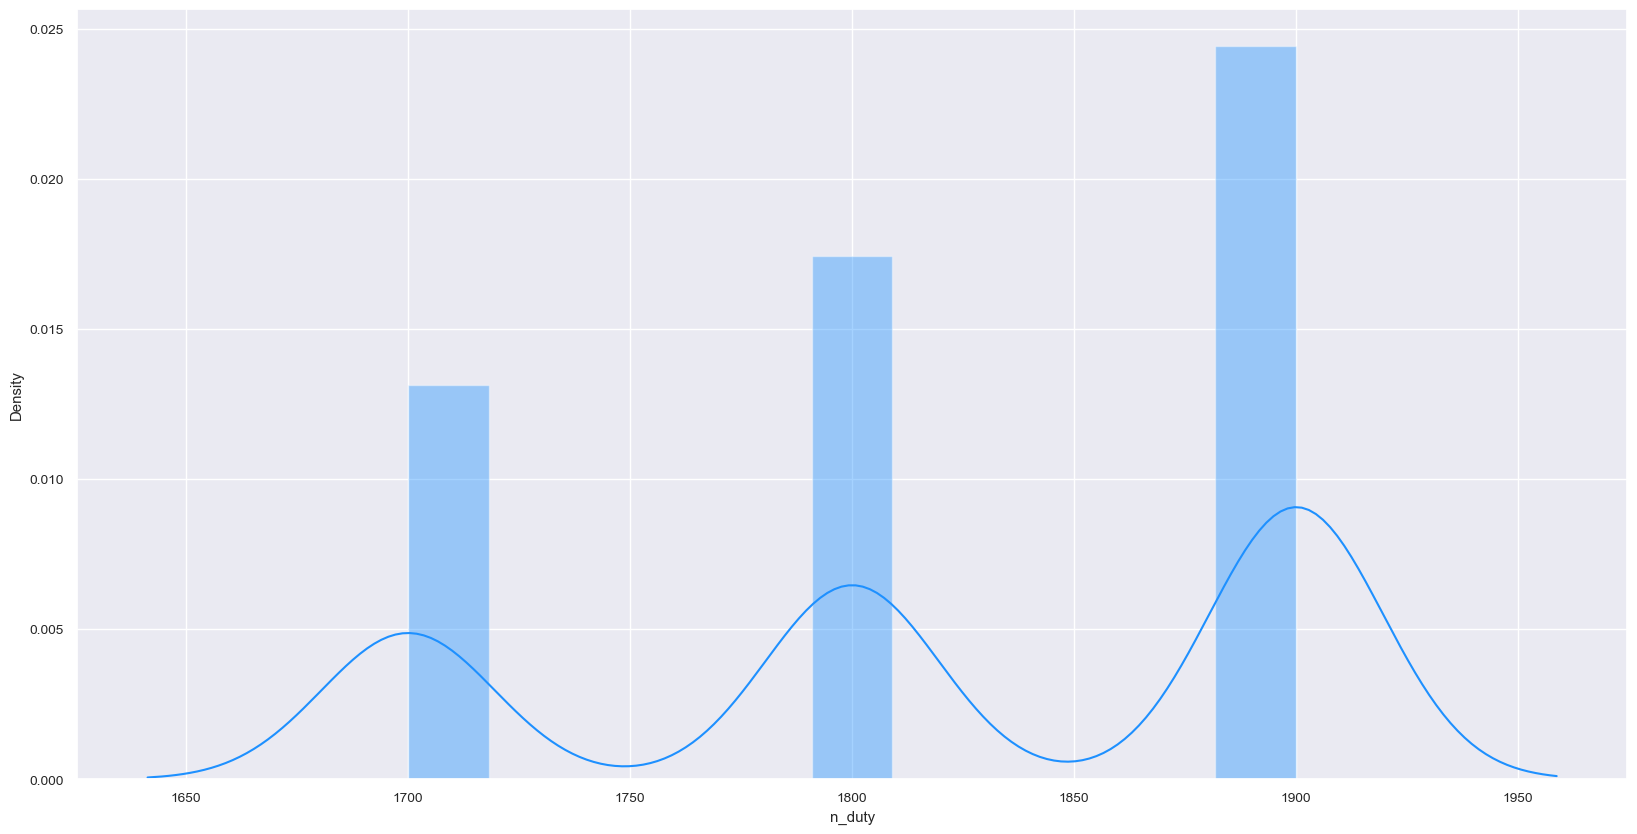

In [129]:
sns.distplot(df["n_duty"], color="dodgerblue")

# save the figure
plt.savefig('images/n_duty_dist.png', dpi=300, bbox_inches='tight')

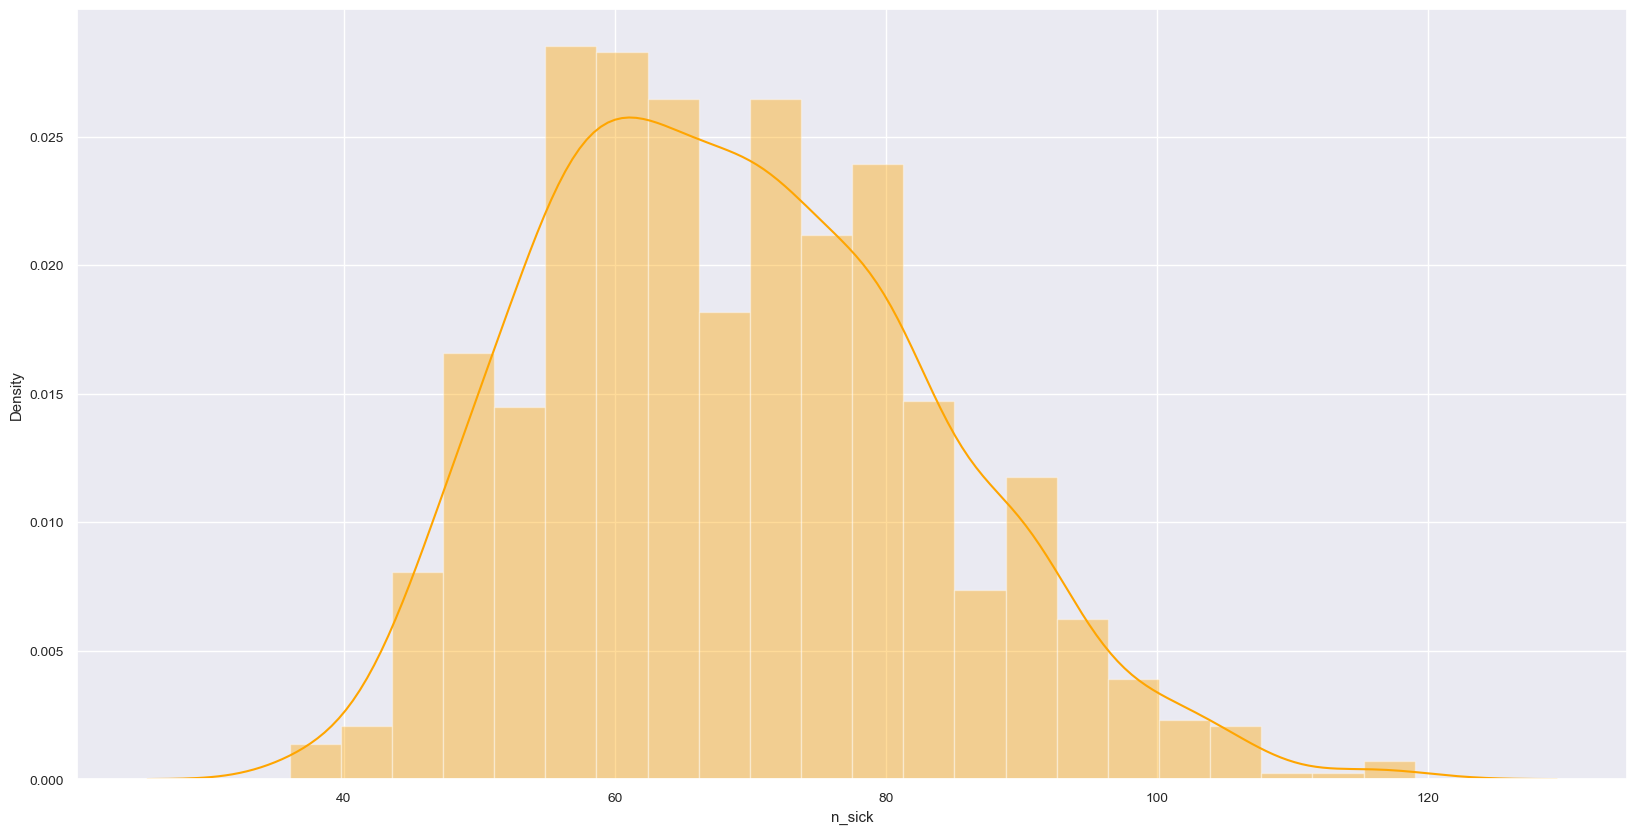

In [130]:
sns.distplot(df["n_sick"], color="orange")
# save the figure
plt.savefig('images/n_sick_dist.png', dpi=300, bbox_inches='tight')

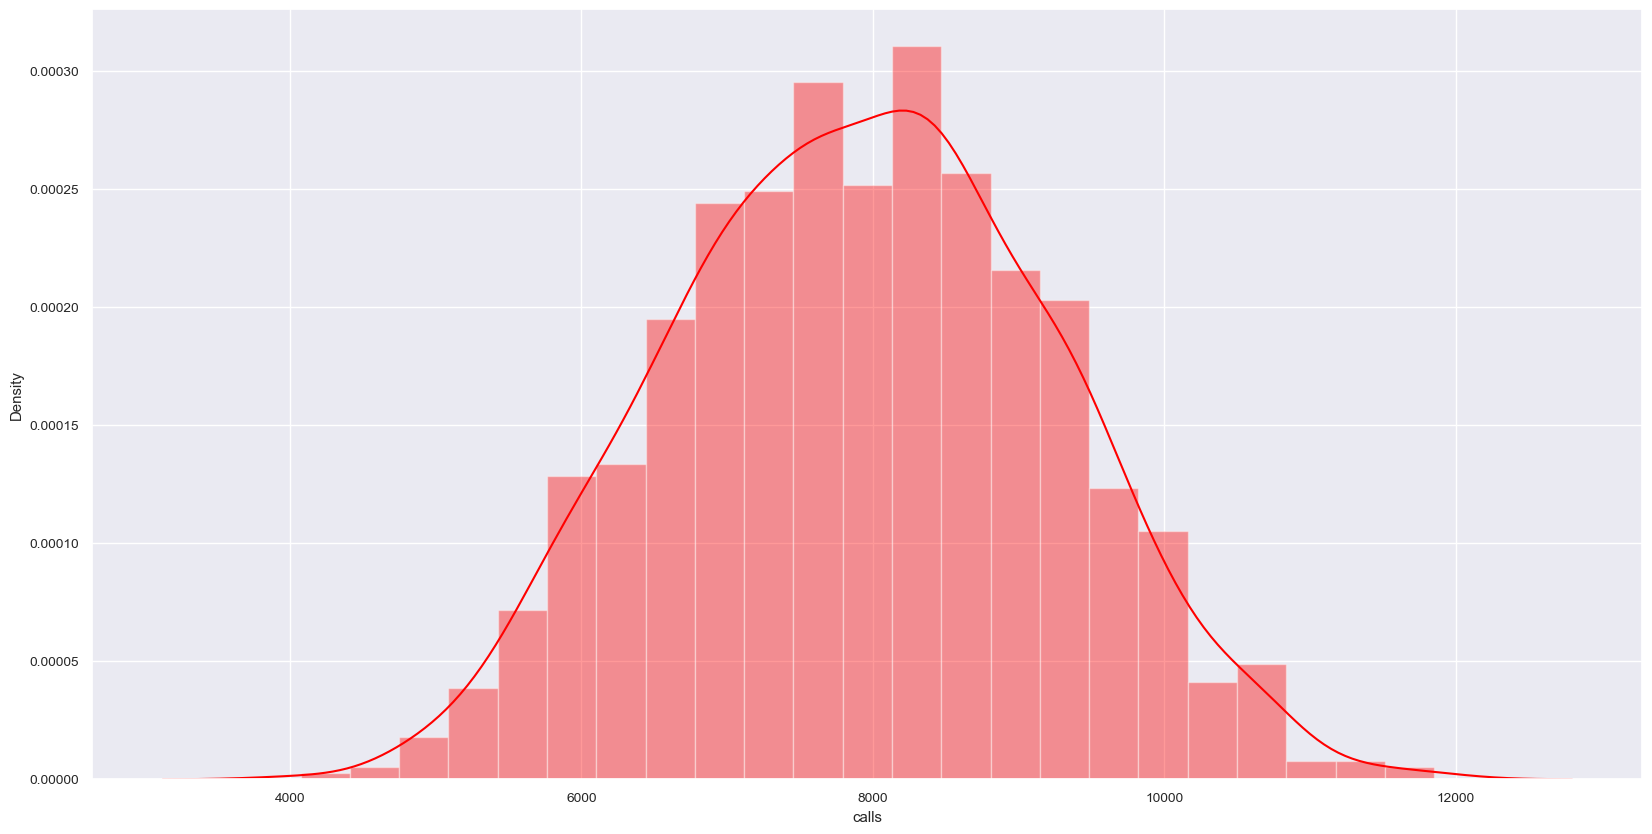

In [131]:
sns.distplot(df["calls"], color="red")
# save the figure
plt.savefig('images/calls_dist.png', dpi=300, bbox_inches='tight')

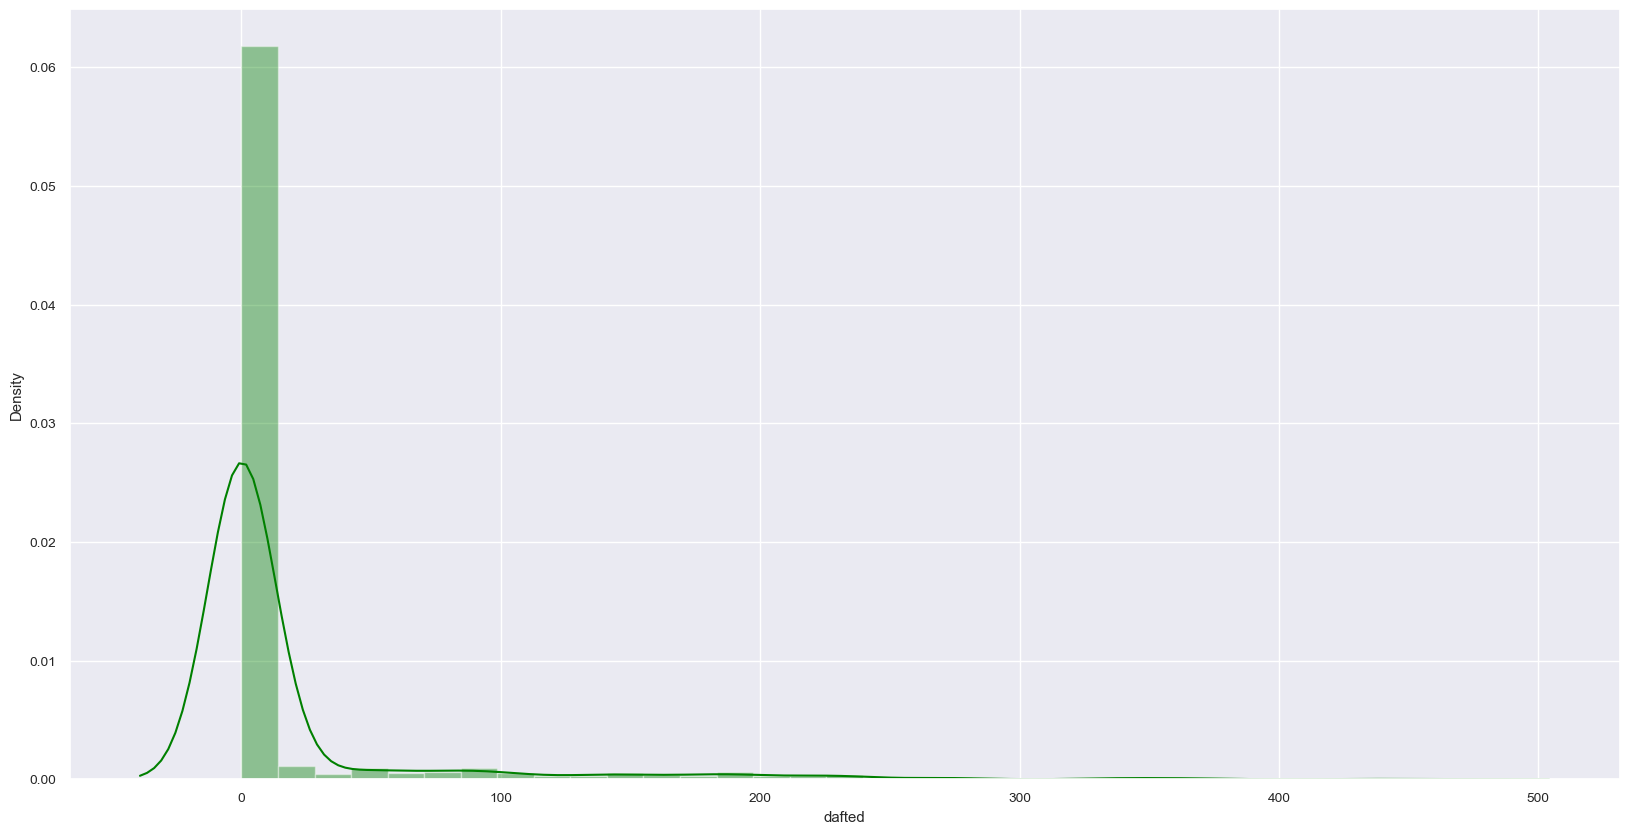

In [132]:
sns.distplot(df["dafted"], color="green")
# save the figure
plt.savefig('images/dafted_dist.png', dpi=300, bbox_inches='tight')

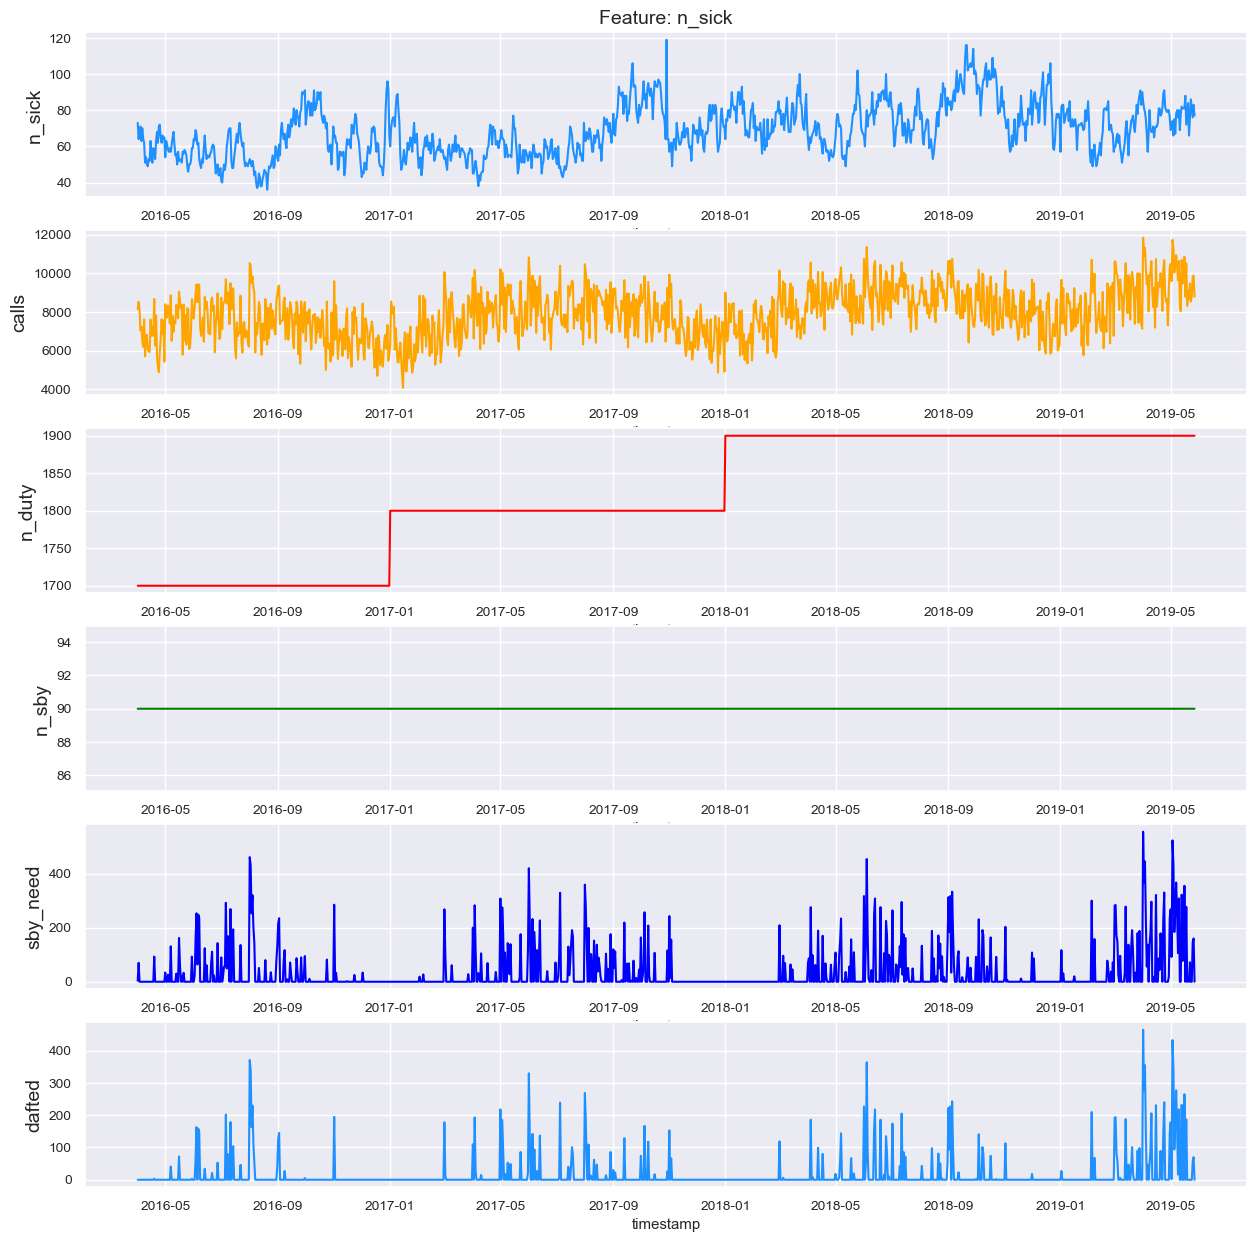

In [134]:
f, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 15))

sns.lineplot(x=df.index, y=df.n_sick, ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: n_sick', fontsize=14)
ax[0].set_ylabel(ylabel='n_sick', fontsize=14)


sns.lineplot(x=df.index, y=df.calls, ax=ax[1], color='orange')
#ax[1].set_title('Feature: calls', fontsize=14)
ax[1].set_ylabel(ylabel='calls', fontsize=14)


sns.lineplot(x=df.index, y=df.n_duty, ax=ax[2], color='red')
#ax[2].set_title('Feature: n_duty', fontsize=14)
ax[2].set_ylabel(ylabel='n_duty', fontsize=14)


sns.lineplot(x=df.index, y=df.n_sby, ax=ax[3], color='green')
#ax[3].set_title('Feature: n_sby', fontsize=14)
ax[3].set_ylabel(ylabel='n_sby', fontsize=14)


sns.lineplot(x=df.index, y=df.sby_need, ax=ax[4], color='blue')
#ax[4].set_title('Target: sby_need', fontsize=14)
ax[4].set_ylabel(ylabel='sby_need', fontsize=14)


sns.lineplot(x=df.index, y=df.dafted, ax=ax[5], color='dodgerblue')
#ax[5].set_title('Target: dafted', fontsize=14)
ax[5].set_ylabel(ylabel='dafted', fontsize=14)


for i in range(6):
    ax[i].set_xlim()


plt.savefig('images/lineplot.png', bbox_inches='tight')
  
plt.show()

### we can recognize a seasonal pettern with light growth of sby_need

## 5- EDA

### - Feature drop

In [18]:
data = df.copy()

In [19]:
# drop 'n_sby','dafted, n_duty' column due to discution of correlation and data understanding 
data = data.drop(['n_sby','dafted','n_duty'], axis =1).copy()


In [20]:
# save data
filepath = Path('Data/sickness_table_droppingfeatures_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath)  

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1152 non-null   object 
 1   n_sick    1152 non-null   int64  
 2   calls     1152 non-null   float64
 3   sby_need  1152 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 45.0+ KB


In [22]:
data.head(3)

,date,n_sick,calls,sby_need
timestamp,,,,
2016-04-01,2016-04-01,73,8154.0,4.0
2016-04-02,2016-04-02,64,8526.0,70.0
2016-04-03,2016-04-03,68,8088.0,0.0


### - Feature extraction

### add actual_duty

In [23]:
data['actual_duty'] = df['n_duty'] - data['n_sick'] + data['sby_need']

### - extract features from date

In [24]:
#add date column as index
data['date']= data.index.copy()

In [25]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['DayOfWeek']=data['date'].dt.day_name()
data['NumDayOfWeek']=data['date'].dt.dayofweek
data['qaurter']=data['date'].dt.quarter

### - add percentage feature

In [26]:
percantage = (data.sby_need / df.n_sby) * 100

In [27]:
data['percantage'] = percantage

In [28]:
data.percantage.mean()

38.57638888888888

In [29]:
percantage_nonzero = (df.where(df.sby_need != 0)/df.n_sby)

In [30]:
perc = (data['sby_need'].where(df.sby_need > df.n_sby))

In [31]:
perc.describe()

count    171.000000
mean     200.052632
std       94.488235
min       91.000000
25%      129.000000
50%      176.000000
75%      258.500000
max      555.000000
Name: sby_need, dtype: float64

In [32]:
data.columns

Index(['date', 'n_sick', 'calls', 'sby_need', 'actual_duty', 'year', 'month',
       'week', 'day', 'DayOfWeek', 'NumDayOfWeek', 'qaurter', 'percantage'],
      dtype='object')

In [33]:
#Reorder columns
new_cols = ['date','n_sick', 'calls',  'actual_duty',  'year', 'month', 'week',
       'day',  'NumDayOfWeek', 'qaurter','percantage','sby_need']

data=data.reindex(columns=new_cols)
data.head(1)

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,percantage,sby_need
timestamp,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1631.0,2016,4,13,1,4,2,4.444444,4.0


In [34]:
# save data
filepath = Path('Data/sickness_table_addedFeatures_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath) 

### Corelation with new features

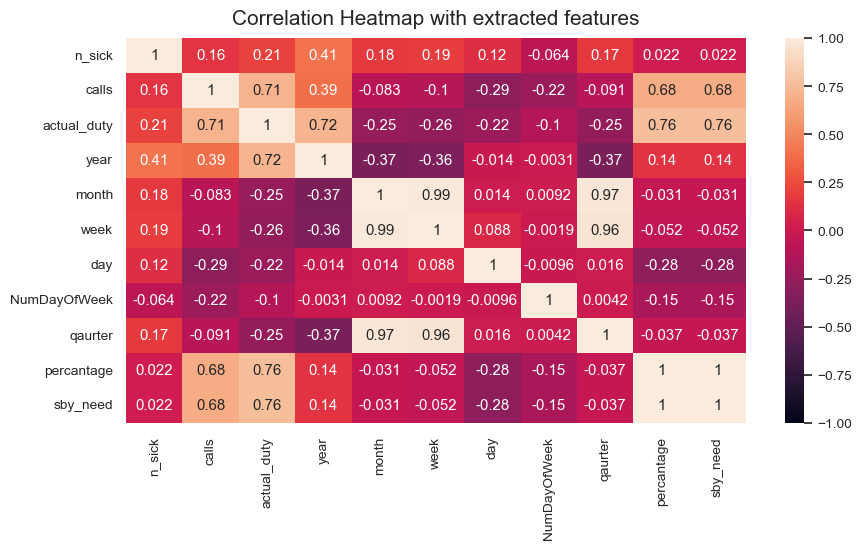

In [135]:
plt.figure(figsize=(10, 5))

heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap with extracted features', fontdict={'fontsize':15}, pad=10);
# save the figure
plt.savefig('images/correlation_Heatmap.png', dpi=300, bbox_inches='tight')

In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
n_sick,1152.0,68.808160,14.293942,36.0,58.00,68.0,78.000000,119.000000
calls,1152.0,7919.531250,1290.063571,4074.0,6978.00,7932.0,8827.500000,11850.000000
actual_duty,1152.0,1786.483507,114.121491,1604.0,1721.75,1796.0,1834.000000,2370.000000
year,1152.0,2017.333333,0.977594,2016.0,2017.00,2017.0,2018.000000,2019.000000
month,1152.0,6.424479,3.394101,1.0,4.00,6.0,9.000000,12.000000
week,1152.0,26.023438,14.770423,1.0,14.00,25.0,39.000000,52.000000
day,1152.0,15.674479,8.778030,1.0,8.00,16.0,23.000000,31.000000
NumDayOfWeek,1152.0,3.002604,2.002386,0.0,1.00,3.0,5.000000,6.000000
qaurter,1152.0,2.484375,1.094858,1.0,2.00,2.0,3.000000,4.000000
percantage,1152.0,38.576389,88.549168,0.0,0.00,0.0,13.611111,616.666667


### Visualize the data according to Years

==


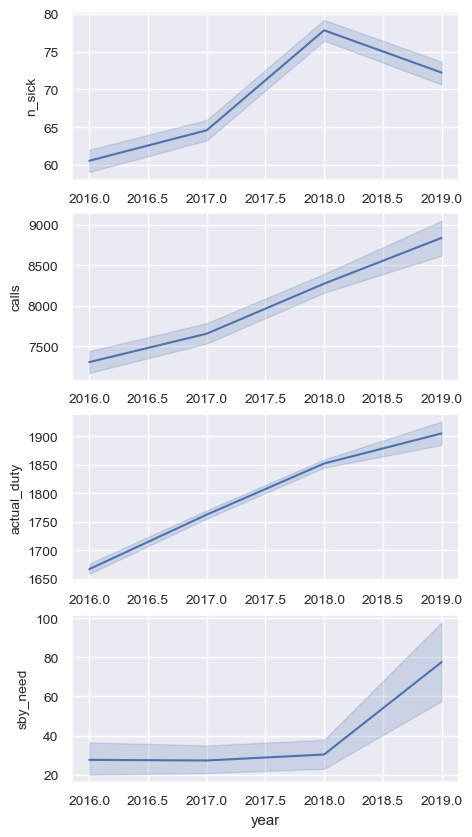

<Figure size 2000x1000 with 0 Axes>

In [136]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(5, 10))
sns.set(font_scale=0.9)
sns.lineplot(x=data.year, y=data.n_sick, ax=ax[0])
#ax[0].set_title('Feature: n_sick', fontsize=10)
ax[0].set_ylabel(ylabel='n_sick', fontsize=10)


sns.lineplot(x=data.year, y=data.calls, ax=ax[1])
#ax[1].set_title('Feature: calls', fontsize=10)
ax[1].set_ylabel(ylabel='calls', fontsize=10)


sns.lineplot(x=data.year, y=data.actual_duty, ax=ax[2])
#ax[2].set_title('Target: actual_duty', fontsize=10)
ax[2].set_ylabel(ylabel='actual_duty', fontsize=10)


sns.lineplot(x=data.year, y=data.sby_need, ax=ax[3])
#ax[3].set_title('Target: sby_need', fontsize=10)
ax[3].set_ylabel(ylabel='sby_need', fontsize=10)
print("==")

for i in range(4):
    
    ax[i].set_xlim()
    
 
    
plt.show()
# save the figure
plt.savefig('images/visual_year.png', dpi=300, bbox_inches='tight')

### monthly, weekly, daily boxplot

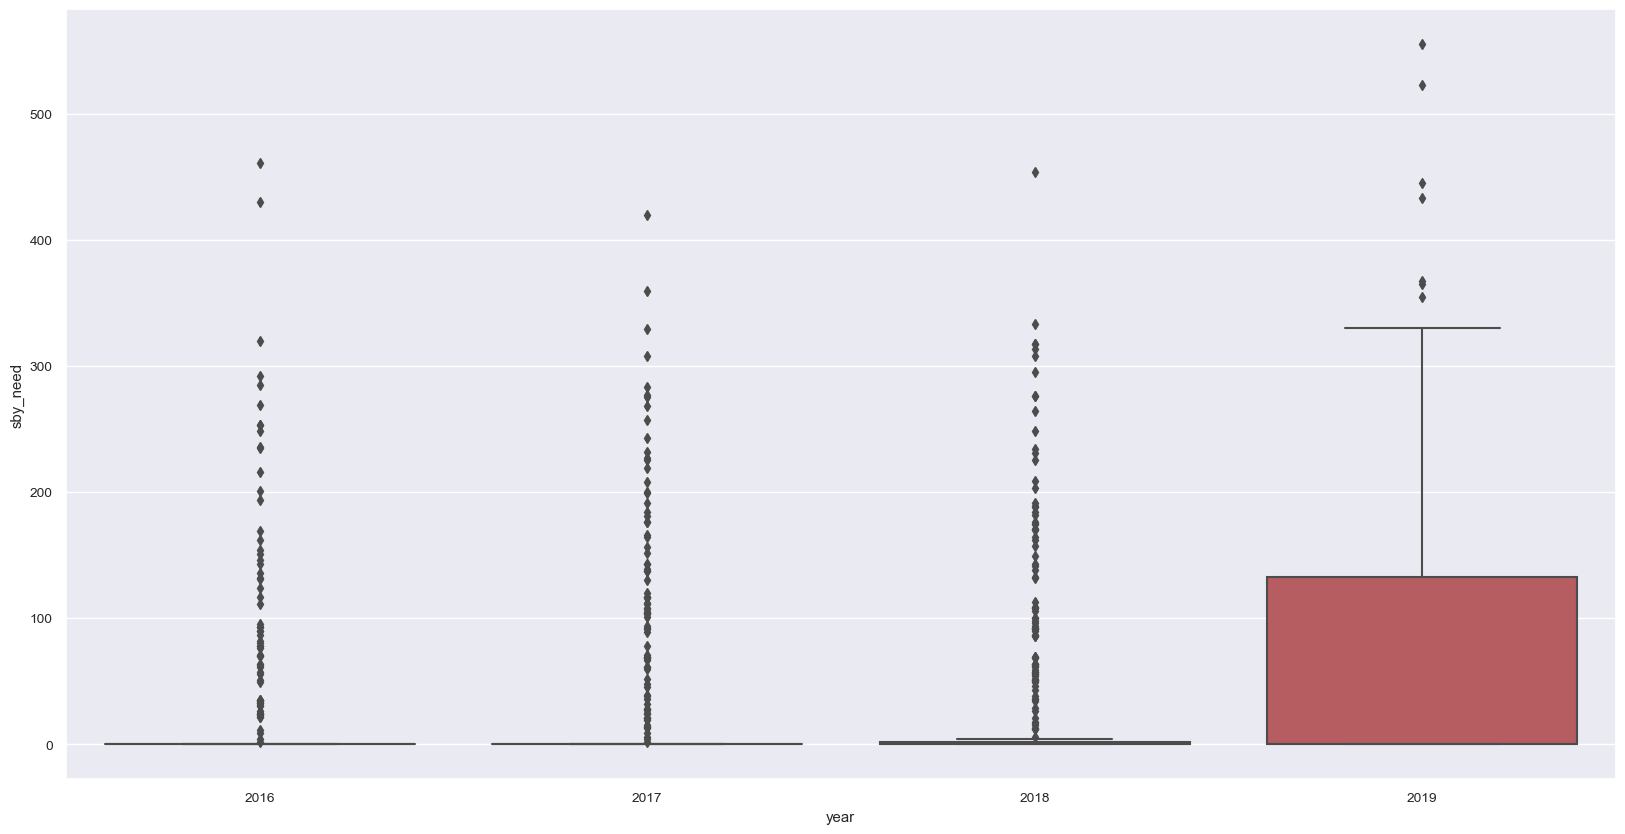

<Figure size 2000x1000 with 0 Axes>

In [138]:
sns.boxplot( x=data['year'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/y_boxplots.png', dpi=300, bbox_inches='tight')

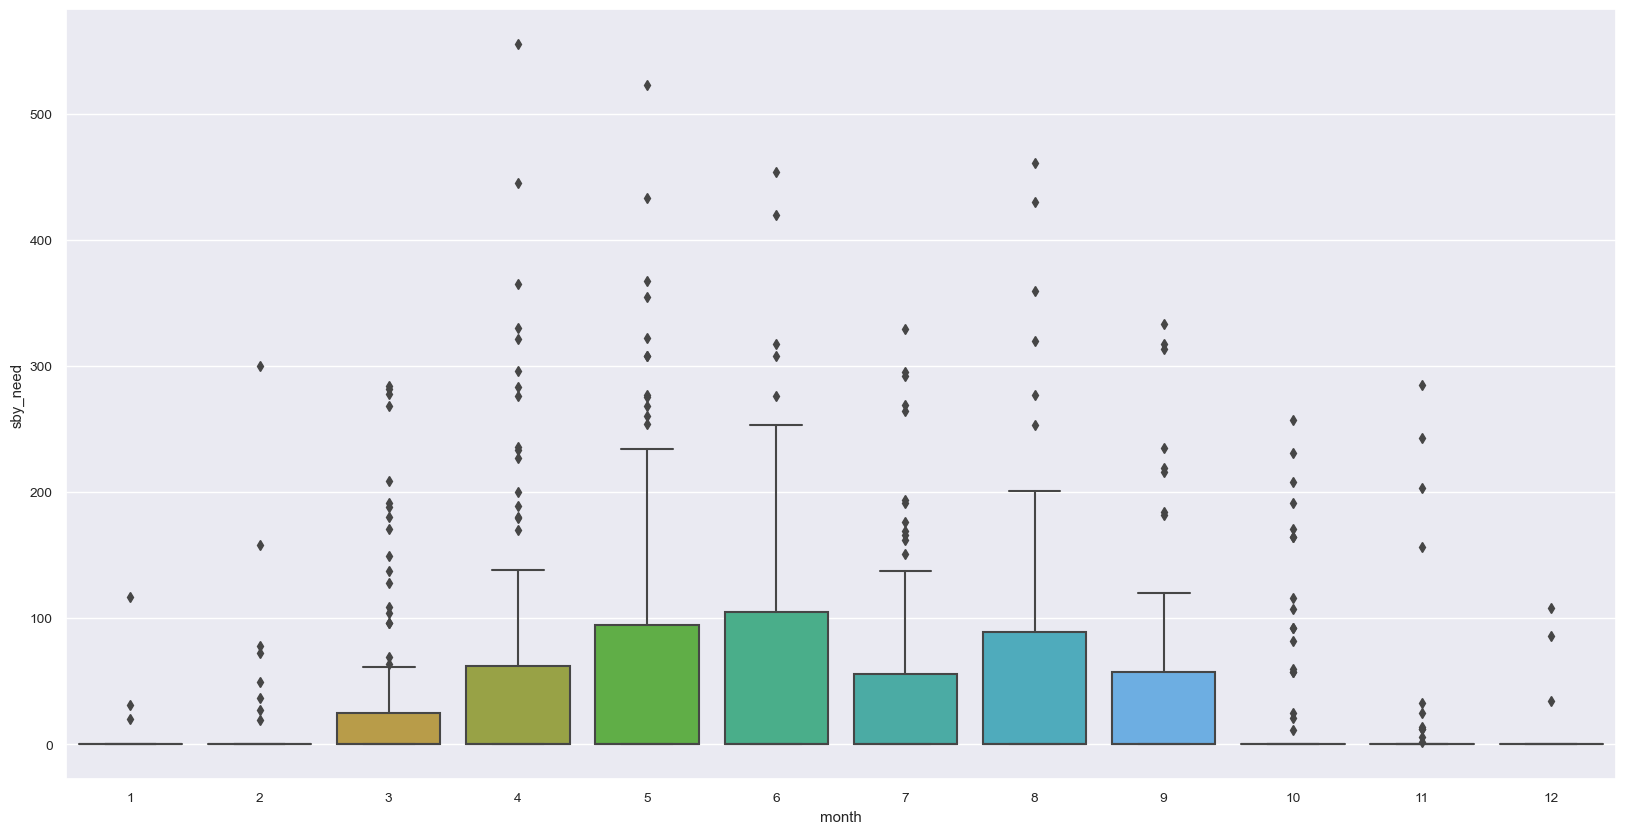

<Figure size 2000x1000 with 0 Axes>

In [139]:
sns.boxplot( x=data['month'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/m_boxplots.png', dpi=300, bbox_inches='tight')

we notice increased demand between March and September, Mai and June max

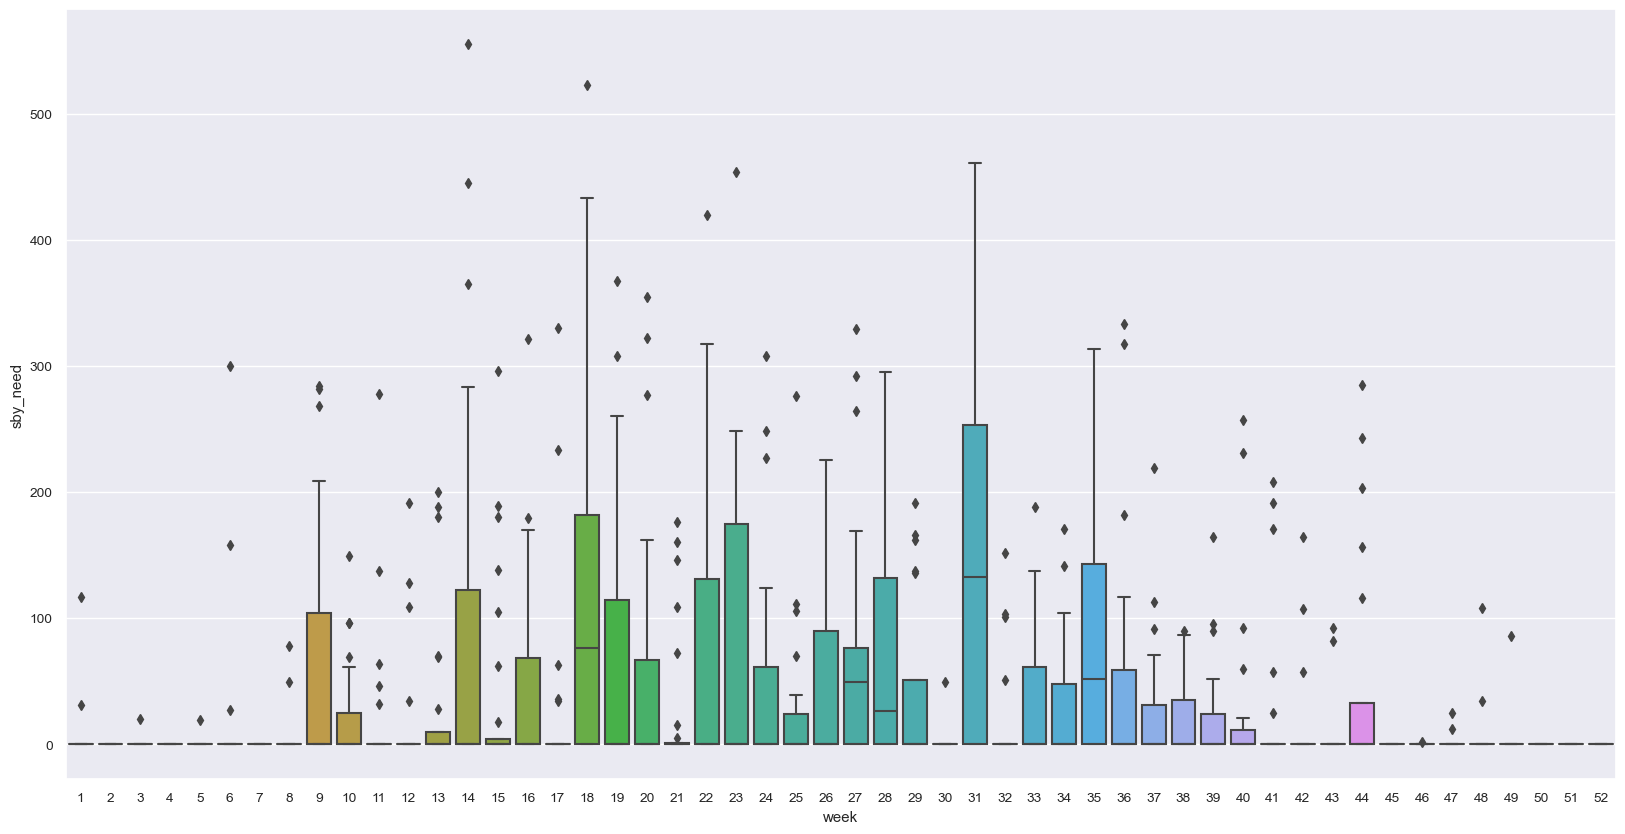

<Figure size 2000x1000 with 0 Axes>

In [140]:
sns.boxplot( x=data['week'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/w_boxplots.png', dpi=300, bbox_inches='tight')

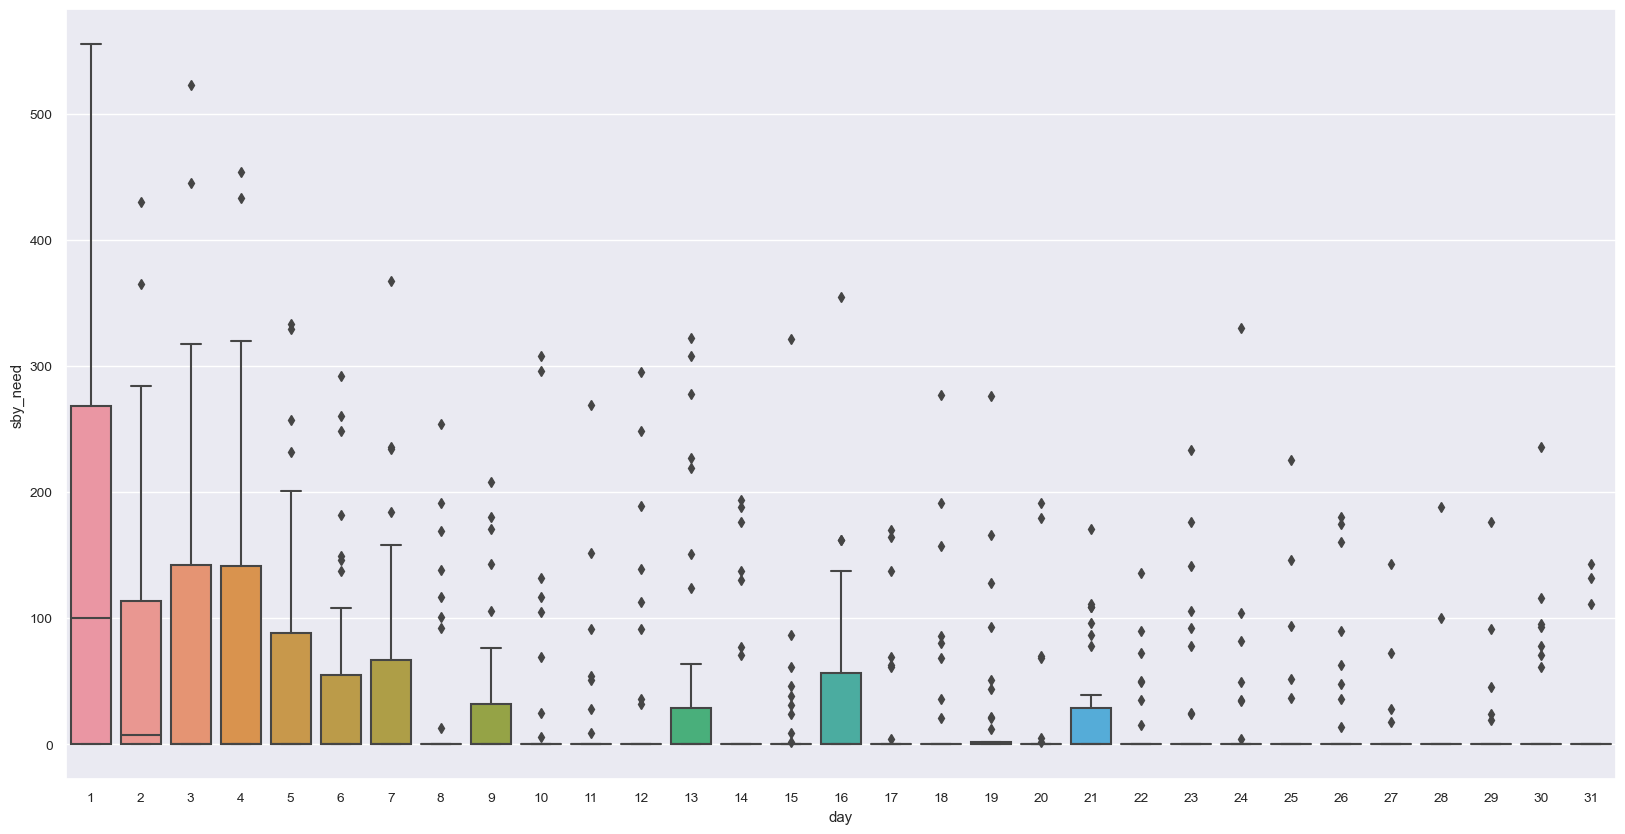

<Figure size 2000x1000 with 0 Axes>

In [141]:

sns.boxplot( x=data['day'],  y=data['sby_need'])
plt.show()
# save the figure
plt.savefig('images/d_boxplots.png', dpi=300, bbox_inches='tight')

We notice increase demand in the first week of the month

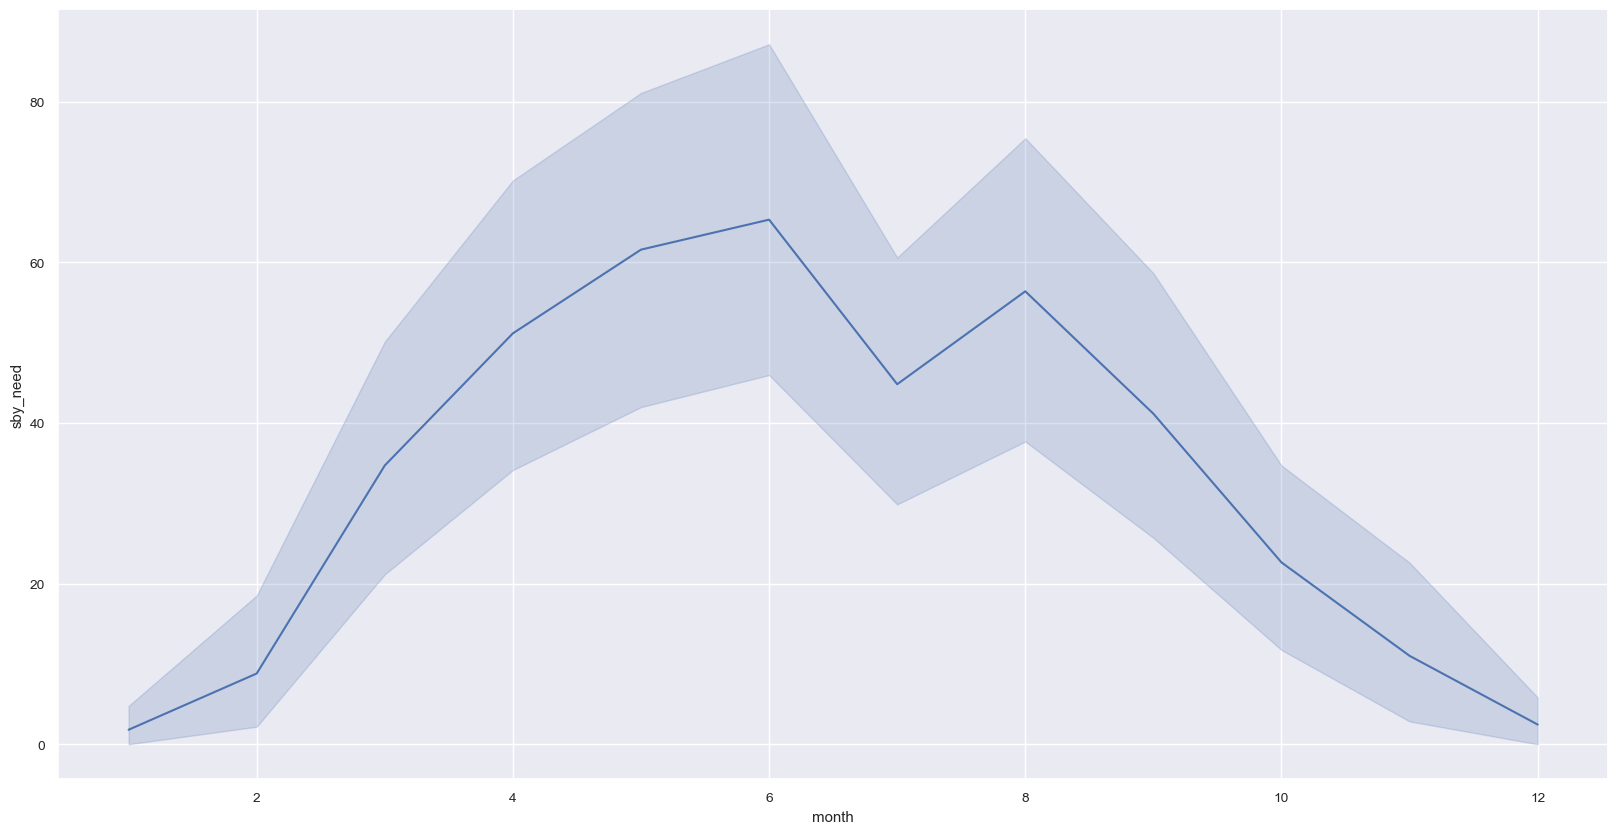

<Figure size 2000x1000 with 0 Axes>

In [142]:

sns.lineplot(data=data, x='month', y='sby_need')
plt.show()
# save the figure
plt.savefig('images/monthly_lineplot.png', dpi=300, bbox_inches='tight')

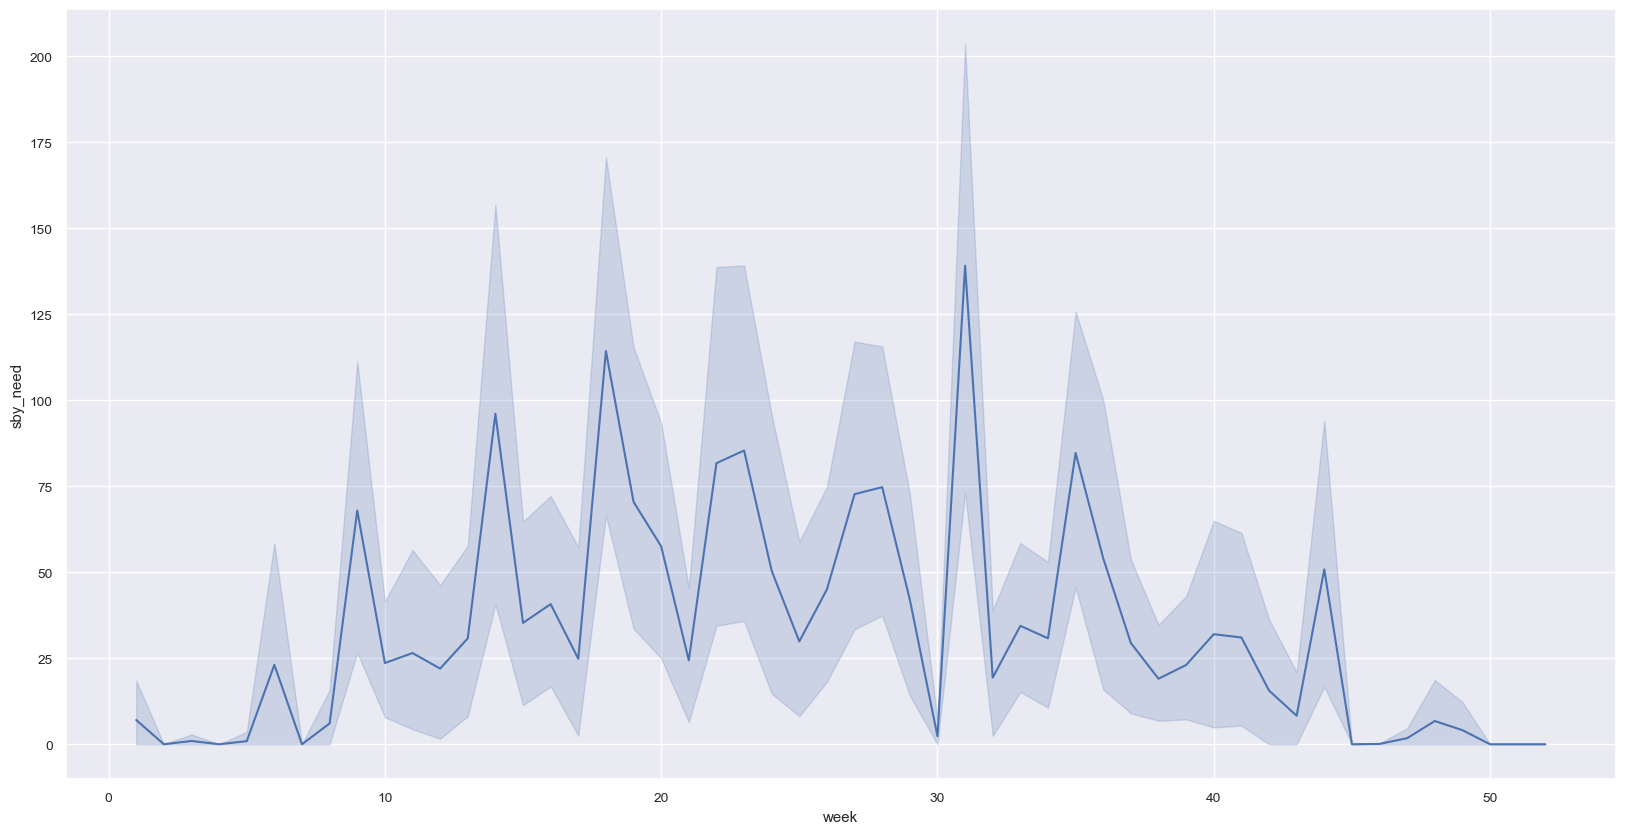

<Figure size 2000x1000 with 0 Axes>

In [143]:
sns.lineplot(data=data, x='week', y='sby_need')
plt.show()
# save the figure
plt.savefig('images/weekly_lineplot.png', dpi=300, bbox_inches='tight')

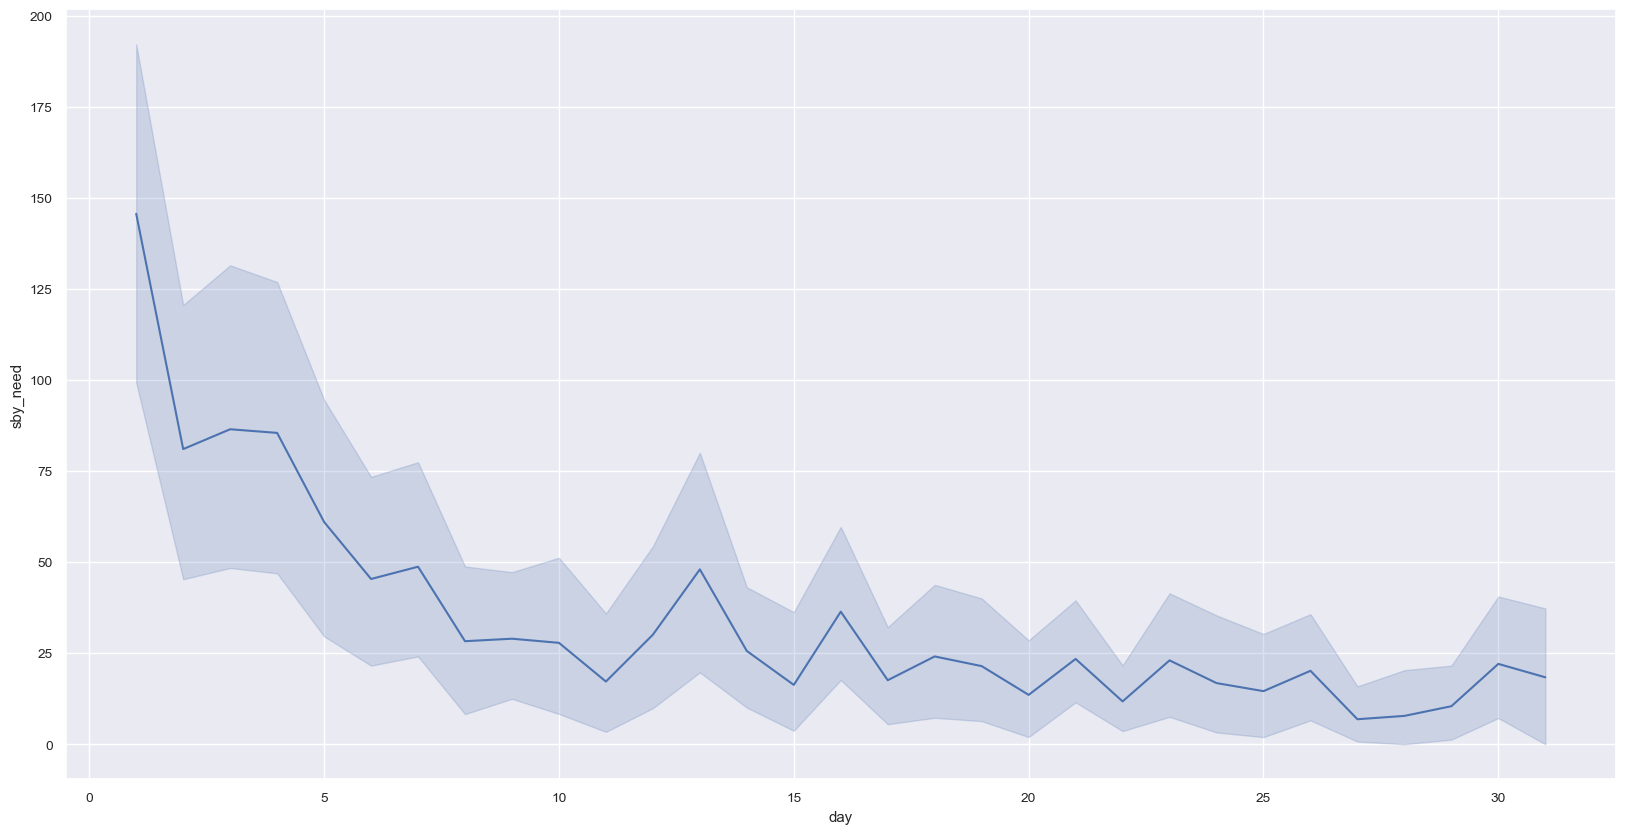

<Figure size 2000x1000 with 0 Axes>

In [144]:
sns.lineplot(data=data, x='day', y='sby_need')
plt.show()
# save the figure
plt.savefig('images/daily_lineplot.png', dpi=300, bbox_inches='tight')

### # above 300 can be conciderd as outliers!

In [45]:
filter = data.where(data['sby_need']<300) 

filter.count()

date            1127
n_sick          1127
calls           1127
actual_duty     1127
year            1127
month           1127
week            1127
day             1127
NumDayOfWeek    1127
qaurter         1127
percantage      1127
sby_need        1127
dtype: int64

In [46]:
data_outl = data[data['sby_need'] < 300].copy()

In [47]:
# save data
filepath = Path('Data/sickness_table_clean_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
data.to_csv(filepath) 

# 6- Model Building

## Baseline Model

In [48]:
data.head(3)

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,percantage,sby_need
timestamp,,,,,,,,,,,,
2016-04-01,2016-04-01,73,8154.0,1631.0,2016,4,13,1,4,2,4.444444,4.0
2016-04-02,2016-04-02,64,8526.0,1706.0,2016,4,13,2,5,2,77.777778,70.0
2016-04-03,2016-04-03,68,8088.0,1632.0,2016,4,13,3,6,2,0.000000,0.0


### the percentage of activated drivers above n_sby =90

In [49]:
(perc.count()/data.shape[0])*100

14.84375

In [50]:
none_Zero= data.where(data.sby_need != 0).count()
none_Zero/1152

date            0.263021
n_sick          0.263021
calls           0.263021
actual_duty     0.263021
year            0.263021
month           0.263021
week            0.263021
day             0.263021
NumDayOfWeek    0.263021
qaurter         0.263021
percantage      0.263021
sby_need        0.263021
dtype: float64

In [51]:
none_Zero_percentage= (none_Zero/df.shape[0])*100
none_Zero_percentage

date            26.302083
n_sick          26.302083
calls           26.302083
actual_duty     26.302083
year            26.302083
month           26.302083
week            26.302083
day             26.302083
NumDayOfWeek    26.302083
qaurter         26.302083
percantage      26.302083
sby_need        26.302083
dtype: float64

### we see that only in about 26.3 % of the time standby drivers were activated

## Model

### Split the data to train/test

In [52]:
formatt ='%Y-%m-%d'
split_date =  datetime.datetime.strptime('2019-01-01',formatt)
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

## Baseline model

In [53]:
def create_features_base(data, label=None):

    X = data[['n_sick', 'calls']]
    if label:
     y = data[label]
     return X, y
     return X

In [54]:
X_train_b, y_train_b = create_features_base (data_train, label='sby_need')
X_test_b, y_test_b =create_features_base (data_test, label='sby_need')

In [55]:
#XGBoost Baseline Model

In [56]:
reg_base = XGBRegressor(n_estimators = 2000, early_stopping_rounds =50, learning_rate =0.01)
reg_base.fit(X_train_b,
       y_train_b,
       eval_set=[(X_train_b, y_train_b), (X_test_b, y_test_b)], eval_metric='rmse', verbose=100)

[20:47:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:73.49590	validation_1-rmse:145.08121
[100]	validation_0-rmse:34.80539	validation_1-rmse:63.53246
[200]	validation_0-rmse:21.52407	validation_1-rmse:43.60768
[300]	validation_0-rmse:16.70960	validation_1-rmse:36.98801
[400]	validation_0-rmse:14.15575	validation_1-rmse:34.66845
[500]	validation_0-rmse:12.96628	validation_1-rmse:33.84583
[600]	validation_0-rmse:12.25131	validation_1-rmse:33.41022
[700]	validation_0-rmse:11.68842	validation_1-rmse:33.39299
[800]	validation_0-rmse:11.37843	validation_1-rmse:33.45582
[900]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [57]:
data.sby_need.mean()

34.71875

In [58]:
data.sby_need.std()

79.6942510683482

## We notice that baseline rmse results are close to the mean of sb_need!!!, so we can use the mean as a baseline model

### Optimize Paraeters using cross validation GridSearchCV()

In [59]:
data.columns

Index(['date', 'n_sick', 'calls', 'actual_duty', 'year', 'month', 'week',
       'day', 'NumDayOfWeek', 'qaurter', 'percantage', 'sby_need'],
      dtype='object')

In [60]:
def create_features(data, label=None):
    data['date'] = data.index
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['DayOfWeek']=data['date'].dt.day_name()
    data['NumDayOfWeek']=data['date'].dt.dayofweek
    data['qaurter']=data['date'].dt.quarter
    X = data[['n_sick', 'calls', 'actual_duty', 'year', 'month', 'week',
       'day', 'NumDayOfWeek', 'qaurter', 'percantage' ]]
    if label:
        y = data[label]
        return X, y
    return X

In [61]:
X_train, y_train = create_features (data_train, label='sby_need')
X_test, y_test =create_features (data_test, label='sby_need')

In [62]:
# A parameter grid for XGBoost
#https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
params = {
    'min_child_weight': [4, 5], #It defines the minimum sum of weights of all observations required in a child.
    'gamma': [i / 10.0 for i in range(1, 6)], #Gamma specifies the minimum loss reduction required to make a split.
    'subsample': [i / 10.0 for i in range(6, 11)],#It denotes the fraction of observations to be randomly samples for each tree.
    'colsample_bytree': [i / 10.0 for i in range(6, 11)], #is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    'max_depth': [2, 3, 4], #The maximum depth of a tree
    'reg_lambda': [0, 0.5, 1, 5]  
    # L2 regularization term on weights. Increasing this value will make model more conservative. 
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror') #regression with squared loss.
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_test, gridcv_xgb.predict(X_test)))
print(mean_absolute_error(y_test, gridcv_xgb.predict(X_test)))
print(np.sqrt(mean_squared_error(y_test, gridcv_xgb.predict(X_test))))

0.9902077554136555
2.4198057732041702
12.28917710829673


In [79]:
xgb_reg

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, nthread=-1, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

### plot feature importance

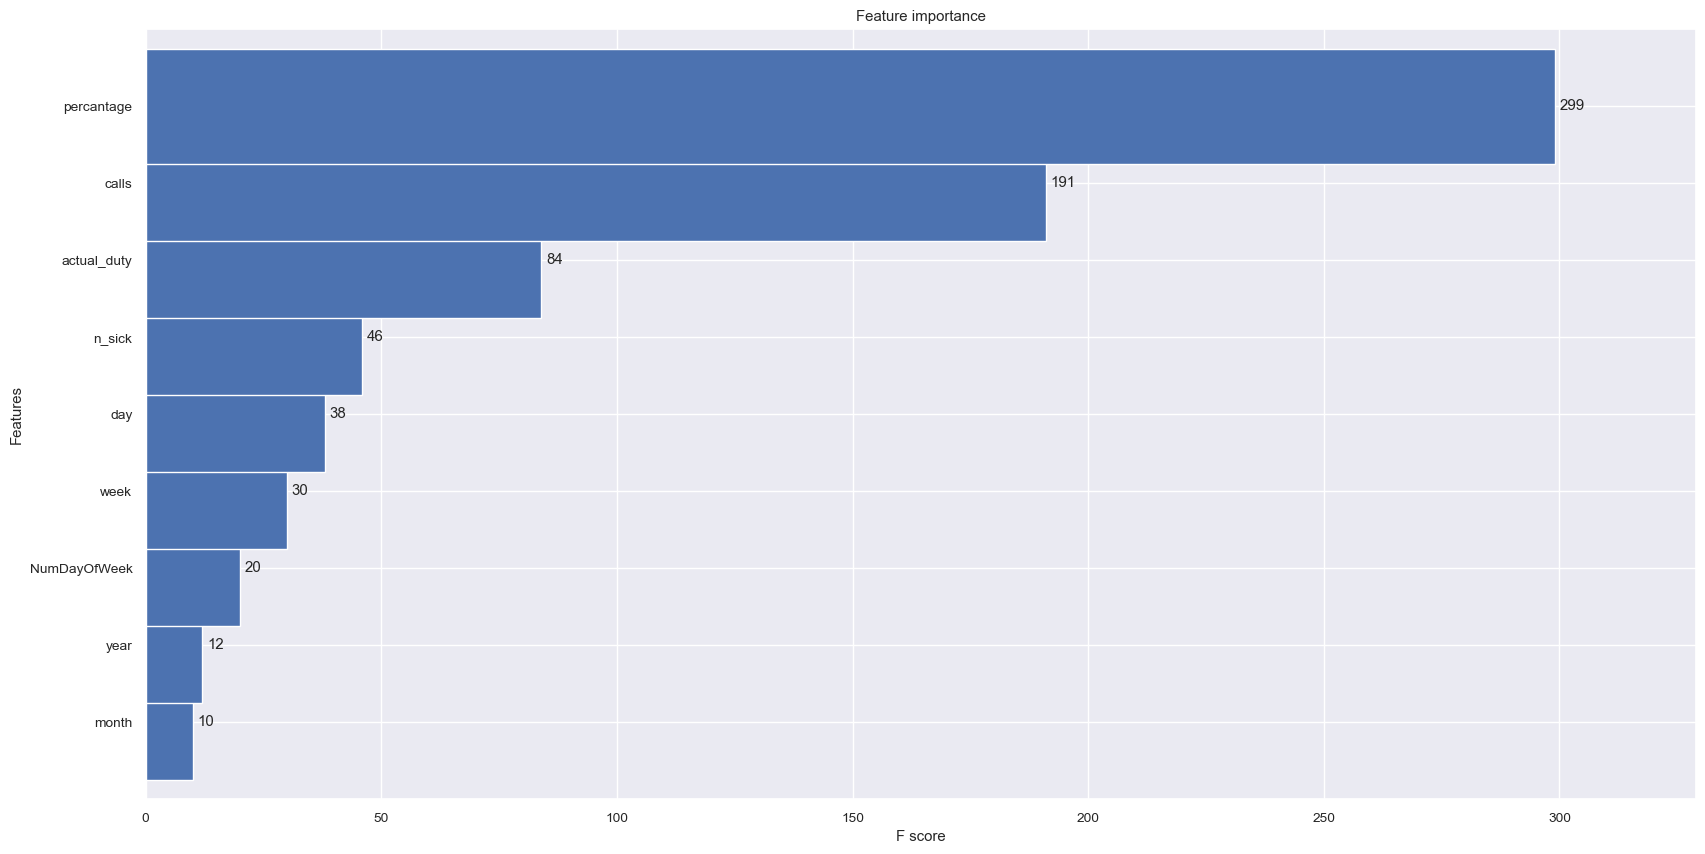

In [145]:
plot_importance(gridcv_xgb, height=1.5)
# save the figure
plt.savefig('images/feature_importance.png', dpi=300, bbox_inches='tight')

### Validation: forcasting on test set

In [64]:
data_test['Prediction'] = gridcv_xgb.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

In [65]:
# evaluate predictions
score = r2_score(y_test, gridcv_xgb.predict(X_test))
print("score: %.2f%%" % (score * 100.0))

score: 99.02%


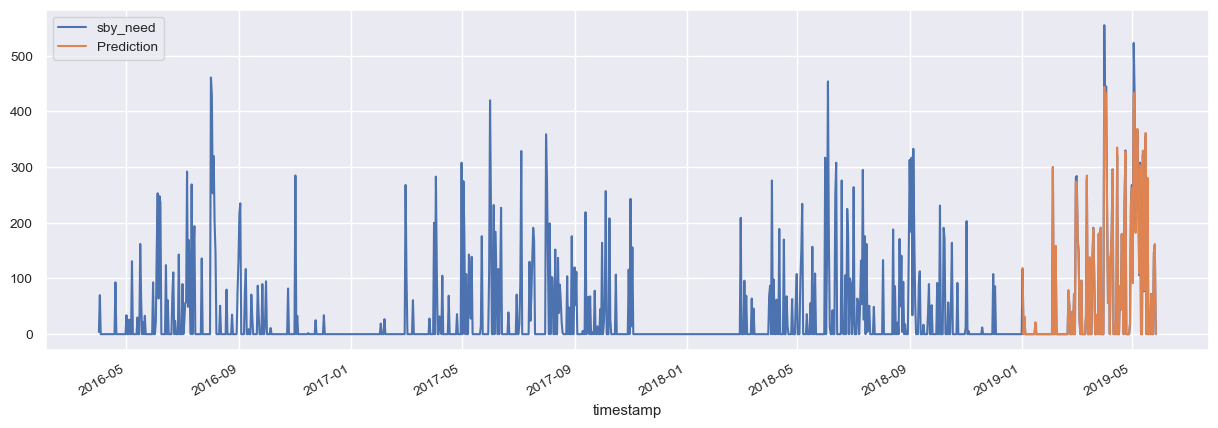

In [150]:
result = data_all[['sby_need','Prediction']].plot(figsize=(15, 5))
# save the figure
plt.savefig('images/visual_pred.png', dpi=300, bbox_inches='tight')

In [67]:
gridcv_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, nthread=-1, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             subsample=1.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [68]:
data_test.tail()

,date,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,percantage,sby_need,DayOfWeek,Prediction
timestamp,,,,,,,,,,,,,,
2019-05-23,2019-05-23,86,8544.0,1814.0,2019,5,21,23,3,2,0.000000,0.0,Thursday,-0.033756
2019-05-24,2019-05-24,81,8814.0,1819.0,2019,5,21,24,4,2,0.000000,0.0,Friday,0.157968
2019-05-25,2019-05-25,76,9846.0,1970.0,2019,5,21,25,5,2,162.222222,146.0,Saturday,146.199432
2019-05-26,2019-05-26,83,9882.0,1977.0,2019,5,21,26,6,2,177.777778,160.0,Sunday,161.871841
2019-05-27,2019-05-27,77,8790.0,1823.0,2019,5,22,27,0,2,0.000000,0.0,Monday,0.150507


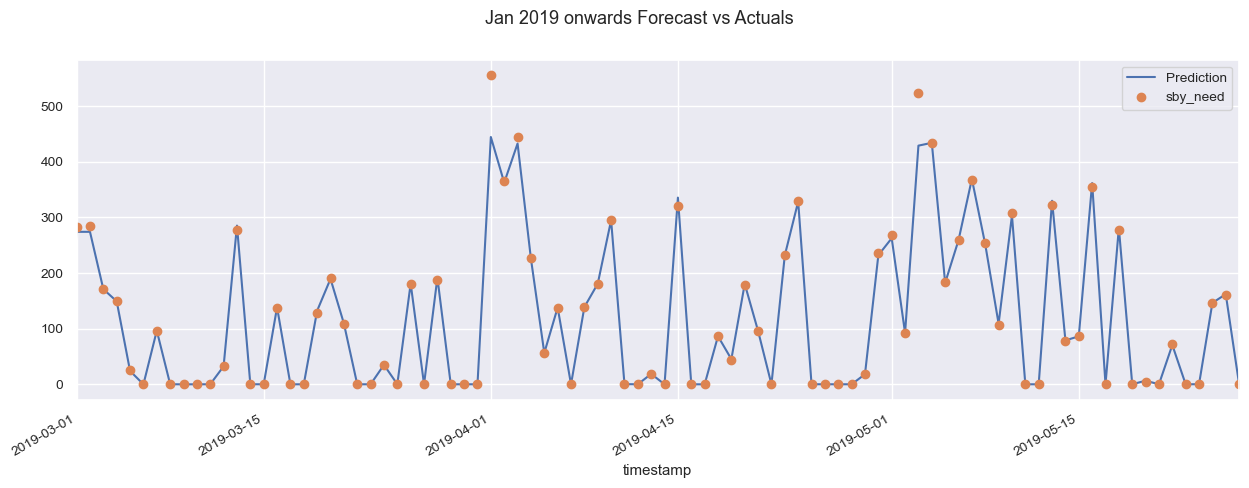

In [151]:
# Plot the forecast with the actuals
import matplotlib.dates as md

left = pd.to_datetime('2019-03-01', format = '%Y-%m-%d')
right = pd.to_datetime('2019-05-27', format = '%Y-%m-%d')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)


#_ = df_all[['Prediction','sby_need']].plot(ax=ax, style=['-','o'])
#ax.set_xbound(lower='2019–05–28', upper='2019–06–27')

#ax.xaxis.set_major_locator(md.MonthLocator(interval = 1))
#ax.xaxis.set_major_formatter(md.DateFormatter('%b'))

ax.set_xlim([left, right])

_ = data_all[['Prediction','sby_need']].plot(ax=ax, style=['-','o'])


plot = plt.suptitle('Jan 2019 onwards Forecast vs Actuals')
#plt.show()
# save the figure
plt.savefig('images/visual_forcast_vs_actual.png', dpi=300, bbox_inches='tight')

## create random data for n_sick   calls   actual_duty


In [116]:
import random
from datetime import date,timedelta
randCalls =[]
randN_sick=[]
randActualDuty=[]
randStb_need=[]

for i in range(1,93):
    
    rc = random.choice(range(int(data['calls'].min()),int(data['calls'].max())) )
    randCalls.append(rc)
    rs = random.choice(range(int(data['n_sick'].min()),int(data['n_sick'].max())) )
    randN_sick.append(rs)
    ra = random.choice(range(int(data['actual_duty'].min()),int(data['actual_duty'].max())) )
    randActualDuty.append(ra)
    ra = random.choice(range(int(data['sby_need'].min()),int(data['sby_need'].max())) )
    randStb_need.append(ra)


def create_future_dates():
    
    start_dt = date(2019,5,28)
    end_dt = date(2019,8,27)
    delta = timedelta(days=1)
    dates =[]
    while start_dt <= end_dt:
        # add current date to list by converting  it to iso format
        dates.append(start_dt.isoformat())
        # increment start date by timedelta
        start_dt += delta
    return dates
    
rand_df= pd.DataFrame({'date': create_future_dates(),
                       'n_sick' : randN_sick,
                       'calls' : randCalls,
                       'actual_duty': randActualDuty,
                      'sby_need':randStb_need},
                     columns=['date','n_sick','calls','actual_duty','sby_need'])



rand_df['date'] = rand_df['date'].apply( lambda x : pd.Timestamp(x))
rand_df.set_index('date', inplace = True)
rand_df.head()

,n_sick,calls,actual_duty,sby_need
date,,,,
2019-05-28,89,9921,2219,60
2019-05-29,103,9965,2258,237
2019-05-30,36,4890,2197,90
2019-05-31,65,8054,2098,443
2019-06-01,89,7622,2323,507


In [117]:
def create_features2(data, label=None):
    rand_df['date'] = pd.to_datetime(rand_df.index)
    rand_df['year'] = (rand_df['date'].dt.year)
    rand_df['month'] = (rand_df['date'].dt.month)
    rand_df['week'] = (rand_df['date'].dt.week)
    rand_df['day'] = (rand_df['date'].dt.day)
    #df['DayOfWeek']=df['date'].dt.day_name()
    rand_df['NumDayOfWeek']=(rand_df['date'].dt.dayofweek)
    rand_df['qaurter']=(rand_df['date'].dt.quarter).astype(int)
    rand_df['percantage']= (rand_df.sby_need / 90) * 100  # took it from data df
    X = rand_df[['n_sick', 'calls', 'actual_duty', 'year', 'month', 'week', 'day','NumDayOfWeek', 'qaurter','percantage']]
    if label:
        y = df[label]
        return X, y
    return X

In [118]:
create_features2(rand_df).head(3)

,n_sick,calls,actual_duty,year,month,week,day,NumDayOfWeek,qaurter,percantage
date,,,,,,,,,,
2019-05-28,89,9921,2219,2019,5,22,28,1,2,66.666667
2019-05-29,103,9965,2258,2019,5,22,29,2,2,263.333333
2019-05-30,36,4890,2197,2019,5,22,30,3,2,100.000000


In [119]:
# save data
filepath = Path('Data/sickness_random_future_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
rand_df.to_csv(filepath) 

In [120]:
test = pd.read_csv('Data/sickness_random_future_final.csv', parse_dates=[0], index_col=[0])
pred_x, pred_y = create_features2(rand_df, label='sby_need')

test['xgb_Prediction'] = gridcv_xgb.predict(pred_x)

test.drop([ 'n_sick', 'calls', 'actual_duty', 'year', 'month', 'week', 'day','qaurter','NumDayOfWeek','percantage','date.1' ], axis=1, inplace=True)
test.head(30)

,sby_need,xgb_Prediction
date,,
2019-05-28,60,63.880791
2019-05-29,237,233.160873
2019-05-30,90,88.286812
2019-05-31,443,424.217773
2019-06-01,507,426.930359
2019-06-02,68,66.642067
2019-06-03,385,363.851013
2019-06-04,260,252.195267
2019-06-05,489,430.984955


In [127]:
print(r2_score(rand_df.sby_need, gridcv_xgb.predict(pred_x)))
print(mean_absolute_error(rand_df.sby_need, gridcv_xgb.predict(pred_x)))
print(np.sqrt(mean_squared_error(rand_df.sby_need, gridcv_xgb.predict(pred_x))))

0.9567140321727771
16.120227554570075
31.77929043673232


In [121]:
# save data
filepath = Path('Data/future_predictions_final.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
test.to_csv(filepath) 

Because of seasonality we can pick the input data for the same month of last year and make our prediction for the next month

ext steps
- More robust cross validation
- Add more features (maybe from external sources) like weather, holidays etc.

# 7- Deploy

In [152]:
gridcv_xgb.save_model('json/model_final.json')

In [153]:
!ls -lh

total 4144
drwxr-xr-x  10 husam  staff   320B Apr 29 20:56 Data
-rw-r--r--   1 husam  staff   1.6M Apr 29 22:58 Task2 -Final.ipynb
drwxr-xr-x  20 husam  staff   640B Apr 29 22:58 images
drwxr-xr-x   3 husam  staff    96B Apr 29 22:59 json
-rw-r--r--   1 husam  staff   199K Apr 29 20:47 lineplot.png
-rw-r--r--   1 husam  staff   121K Apr 29 22:30 model_final.json


In [154]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('json/model_final.json')

In [155]:
reg_new.predict(pred_x)

array([ 63.88079 , 233.16087 ,  88.28681 , 424.21777 , 426.93036 ,
        66.64207 , 363.851   , 252.19527 , 430.98495 , 425.9689  ,
       433.35226 , 142.82176 , 224.61267 , 438.6359  ,  50.631428,
       426.63968 , 111.07091 , 277.28513 , 425.22345 , 222.57741 ,
       435.0464  , 366.32358 , 425.7177  , 299.26895 , 307.95944 ,
       215.01918 ,  89.9622  , 379.8128  , 114.1831  , 318.6056  ,
       424.9081  ,  61.323017, 120.338066, 212.78038 , 295.3222  ,
       179.18593 , 178.8339  , 246.7484  , 430.84863 , 430.01257 ,
       425.03925 ,  68.66111 , 323.98233 , 287.50638 , 356.0627  ,
       101.931625, 138.71054 , 134.69627 ,  15.824987,  81.459724,
       431.04242 , 316.22372 , 430.61633 , 426.57016 , 316.30124 ,
       158.13525 , 204.40059 , 359.635   , 119.98176 , 101.54561 ,
        60.9607  , 126.14136 , 275.37152 , 358.12308 ,  69.65612 ,
       424.71948 , 427.51852 , 198.38525 , 434.92944 , 178.70137 ,
       185.05772 ,  10.200839,  77.67415 , 189.17157 , 256.379